# Task 2: Text Chunking, Embeddings & Vector Indexing

**Project:** Intelligent Complaint Analysis Platform  
**Client:** CrediTrust Financial  
**Objective:** Convert cleaned complaint narratives into a production-ready semantic search index   
**Date:** 2024

---

## Executive Summary

This notebook implements the embedding generation and vector indexing pipeline for the RAG system. It transforms cleaned complaint narratives from Task 1 into a searchable semantic knowledge base using:

- **Stratified Sampling**: 10,000-15,000 complaints with proportional representation across product categories
- **Text Chunking**: RecursiveCharacterTextSplitter optimized for complaint narratives
- **Embeddings**: sentence-transformers/all-MiniLM-L6-v2 (384-dimensional vectors)
- **Vector Store**: FAISS index with comprehensive metadata preservation

**Business Impact**: Enables fast semantic retrieval for Product, Support, and Compliance teams to answer questions like:
- "What issues are trending in Credit Cards?"
- "Are Money Transfer complaints increasing due to delays or fraud?"


## 1. Environment Setup and Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle
from datetime import datetime

# Embedding and vector store libraries
from sentence_transformers import SentenceTransformer
import faiss
from langchain_text_splitters import RecursiveCharacterTextSplitter

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 50)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Define paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / 'data'
VECTOR_STORE_DIR = PROJECT_ROOT / 'vector_store'
VECTOR_STORE_DIR.mkdir(exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Vector store directory: {VECTOR_STORE_DIR}")


Project root: d:\Senait Doc\KAIM 8 Doc\Intelligent-Complaint-Analysis
Data directory: d:\Senait Doc\KAIM 8 Doc\Intelligent-Complaint-Analysis\data
Vector store directory: d:\Senait Doc\KAIM 8 Doc\Intelligent-Complaint-Analysis\vector_store


## 2. Data Loading and Product Category Mapping


In [2]:
# Load the filtered complaints dataset
print("=" * 80)
print("LOADING FILTERED COMPLAINTS DATASET")
print("=" * 80)

input_file = DATA_DIR / 'filtered_complaints.csv'
df = pd.read_csv(input_file)

print(f"\nDataset loaded: {len(df):,} complaints")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head(3))

# Create complaint_id from index (since original Complaint ID is not in the CSV)
df['complaint_id'] = df.index.astype(str)

# Map products to standardized categories
def map_to_product_category(product):
    """Map CFPB product names to CrediTrust product categories"""
    product_lower = str(product).lower()
    
    if 'credit card' in product_lower or 'prepaid card' in product_lower:
        return 'Credit Cards'
    elif 'loan' in product_lower and ('personal' in product_lower or 'payday' in product_lower):
        return 'Personal Loans'
    elif 'checking' in product_lower or 'savings' in product_lower:
        return 'Savings Accounts'
    elif 'money transfer' in product_lower or 'money service' in product_lower or 'virtual currency' in product_lower:
        return 'Money Transfers'
    else:
        return 'Other'

df['product_category'] = df['Product'].apply(map_to_product_category)

# Filter to only the four target categories
target_categories = ['Credit Cards', 'Personal Loans', 'Savings Accounts', 'Money Transfers']
df_filtered = df[df['product_category'].isin(target_categories)].copy()

print(f"\n" + "=" * 80)
print("PRODUCT CATEGORY MAPPING")
print("=" * 80)
print(f"\nAfter filtering to target categories: {len(df_filtered):,} complaints")
print(f"\nProduct category distribution:")
print(df_filtered['product_category'].value_counts().sort_index())
print(f"\nPercentage distribution:")
print((df_filtered['product_category'].value_counts(normalize=True) * 100).sort_index().round(2))


LOADING FILTERED COMPLAINTS DATASET

Dataset loaded: 462,050 complaints
Columns: ['narrative', 'Product', 'Date received', 'Date sent to company', 'Company public response', 'cleaned_word_count', 'Consumer complaint narrative']

First few rows:
                                                                                             narrative  \
0  a xxxx xxxx card was opened under my name by a fraudster. i received a notice from xxxx that an ...   
1  i made the mistake of using my wellsfargo debit card to depsit funds into xxxxxxxx atm machine o...   
2  dear cfpb, i have a secured credit card with citibank which is changed to unsecured card and i h...   

                       Product Date received Date sent to company  \
0                  Credit card    2025-06-13           2025-06-13   
1  Checking or savings account    2025-06-13           2025-06-13   
2                  Credit card    2025-06-12           2025-06-13   

                                                     

## 3. Stratified Sampling (10,000-15,000 Complaints)


In [3]:
# Stratified sampling to get 12,000 complaints (within 10K-15K range)
# Maintaining proportional representation across product categories

TARGET_SAMPLE_SIZE = 12000

print("=" * 80)
print("STRATIFIED SAMPLING")
print("=" * 80)
print(f"\nTarget sample size: {TARGET_SAMPLE_SIZE:,} complaints")
print(f"Total available: {len(df_filtered):,} complaints")

# Calculate sampling ratios for each category
category_counts = df_filtered['product_category'].value_counts()
total_available = len(df_filtered)

# Calculate how many to sample from each category (proportional)
sample_sizes = {}
for category in target_categories:
    if category in category_counts.index:
        proportion = category_counts[category] / total_available
        sample_sizes[category] = max(1, int(TARGET_SAMPLE_SIZE * proportion))
    else:
        sample_sizes[category] = 0

# Adjust to ensure we hit the target size exactly
total_allocated = sum(sample_sizes.values())
if total_allocated != TARGET_SAMPLE_SIZE:
    difference = TARGET_SAMPLE_SIZE - total_allocated
    # Add/subtract from the largest category
    largest_category = max(sample_sizes.items(), key=lambda x: x[1])[0]
    sample_sizes[largest_category] += difference

# Perform stratified sampling
sampled_dfs = []
for category in target_categories:
    if category in category_counts.index:
        category_df = df_filtered[df_filtered['product_category'] == category]
        n_sample = min(sample_sizes[category], len(category_df))
        if n_sample > 0:
            sampled = category_df.sample(n=n_sample, random_state=42)
            sampled_dfs.append(sampled)

df_sampled = pd.concat(sampled_dfs, ignore_index=True)

print(f"\nActual sampled size: {len(df_sampled):,} complaints")
print(f"\nSampled category distribution:")
print(df_sampled['product_category'].value_counts().sort_index())
print(f"\nPercentage distribution:")
print((df_sampled['product_category'].value_counts(normalize=True) * 100).sort_index().round(2))

# Verify narrative quality
print(f"\nNarrative quality check:")
print(f"  Non-null narratives: {df_sampled['narrative'].notna().sum():,}")
print(f"  Average word count: {df_sampled['cleaned_word_count'].mean():.1f}")
print(f"  Median word count: {df_sampled['cleaned_word_count'].median():.1f}")


STRATIFIED SAMPLING

Target sample size: 12,000 complaints
Total available: 462,050 complaints

Actual sampled size: 12,000 complaints

Sampled category distribution:
product_category
Credit Cards        5119
Money Transfers     2562
Personal Loans       678
Savings Accounts    3641
Name: count, dtype: int64

Percentage distribution:
product_category
Credit Cards        42.66
Money Transfers     21.35
Personal Loans       5.65
Savings Accounts    30.34
Name: proportion, dtype: float64

Narrative quality check:
  Non-null narratives: 12,000
  Average word count: 207.6
  Median word count: 140.0


## 4. Text Chunking Strategy

**Decision Rationale:**
- Complaint narratives are typically 20-500 words (from Task 1 analysis)
- Most narratives are complete thoughts that shouldn't be split
- Only narratives >500 words need chunking to preserve context
- Using RecursiveCharacterTextSplitter with:
  - `chunk_size=500`: Captures full context while staying within model limits
  - `chunk_overlap=50`: Ensures continuity at chunk boundaries
  - Separators: `["\n\n", "\n", ". ", " ", ""]` to respect natural text structure


TEXT CHUNKING ANALYSIS

Narrative length statistics (characters):
count    12000.000000
mean      1131.480833
std       1289.450572
min         21.000000
25%        458.000000
50%        747.000000
75%       1372.000000
max      31337.000000
Name: narrative, dtype: float64

Narratives requiring chunking (>500 chars): 8,706 (72.5%)
Narratives as single chunks: 3,294 (27.5%)

CHUNKING RESULTS

Total chunks created: 37,225
Average chunks per complaint: 3.10

Chunk length statistics (characters):
  Mean: 368.6
  Median: 406.0
  Min: 6
  Max: 500


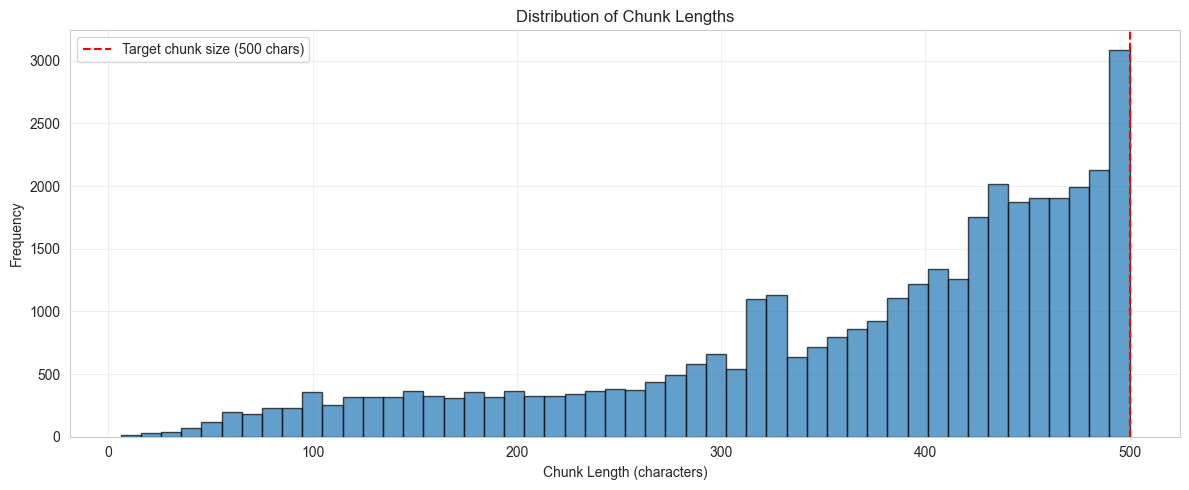

In [4]:
# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,          # Characters per chunk
    chunk_overlap=50,        # Overlap between chunks
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]  # Respect natural text boundaries
)

print("=" * 80)
print("TEXT CHUNKING ANALYSIS")
print("=" * 80)

# Analyze narrative lengths
narrative_lengths = df_sampled['narrative'].str.len()
print(f"\nNarrative length statistics (characters):")
print(narrative_lengths.describe())

# Determine which narratives need chunking (those >500 chars roughly correspond to >100 words)
chunking_threshold = 500  # characters
needs_chunking = narrative_lengths > chunking_threshold
print(f"\nNarratives requiring chunking (>500 chars): {needs_chunking.sum():,} ({needs_chunking.sum()/len(df_sampled)*100:.1f}%)")
print(f"Narratives as single chunks: {(~needs_chunking).sum():,} ({(~needs_chunking).sum()/len(df_sampled)*100:.1f}%)")

# Create chunks with metadata
chunks = []
metadata_list = []

for idx, row in df_sampled.iterrows():
    narrative = str(row['narrative'])
    complaint_id = row['complaint_id']
    
    # Split text into chunks
    text_chunks = text_splitter.split_text(narrative)
    
    # Create a chunk entry for each split
    for chunk_idx, chunk_text in enumerate(text_chunks):
        chunks.append(chunk_text)
        
        # Preserve metadata for traceability
        metadata = {
            'complaint_id': complaint_id,
            'product_category': row['product_category'],
            'product': row['Product'],
            'date_received': str(row['Date received']) if pd.notna(row['Date received']) else None,
            'chunk_index': chunk_idx,
            'total_chunks': len(text_chunks),
            'original_word_count': row['cleaned_word_count'] if pd.notna(row['cleaned_word_count']) else len(narrative.split())
        }
        metadata_list.append(metadata)

print(f"\n" + "=" * 80)
print("CHUNKING RESULTS")
print("=" * 80)
print(f"\nTotal chunks created: {len(chunks):,}")
print(f"Average chunks per complaint: {len(chunks)/len(df_sampled):.2f}")
print(f"\nChunk length statistics (characters):")
chunk_lengths = [len(chunk) for chunk in chunks]
print(f"  Mean: {np.mean(chunk_lengths):.1f}")
print(f"  Median: {np.median(chunk_lengths):.1f}")
print(f"  Min: {np.min(chunk_lengths)}")
print(f"  Max: {np.max(chunk_lengths)}")

# Visualize chunk distribution
plt.figure(figsize=(12, 5))
plt.hist(chunk_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(500, color='red', linestyle='--', label='Target chunk size (500 chars)')
plt.xlabel('Chunk Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Chunk Lengths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Embedding Model Selection

**Model: sentence-transformers/all-MiniLM-L6-v2**

**Rationale:**
- **Speed**: Fast inference (optimized for production)
- **Quality**: Strong semantic understanding for short-to-medium text (complaints are typically 20-500 words)
- **Dimension**: 384-dimensional vectors (good balance between quality and storage)
- **Domain**: General-purpose model works well for financial complaint narratives
- **Trade-off**: Slightly less semantic depth than larger models (e.g., all-mpnet-base-v2), but 3-5x faster inference, which is critical for real-time RAG retrieval

**Alternative Considered**: all-mpnet-base-v2 (768-dim, higher quality but slower)
- Rejected due to speed requirements for interactive chatbot


In [ ]:
print("=" * 80)
print("EMBEDDING GENERATION")
print("=" * 80)

# Initialize the embedding model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
print(f"\nLoading embedding model: {model_name}")
print("This may take a minute on first run (downloads model if needed)...")

embedding_model = SentenceTransformer(model_name)

print(f"Model loaded successfully!")
print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# Generate embeddings for all chunks
print(f"\nGenerating embeddings for {len(chunks):,} chunks...")
print("This may take several minutes...")

embeddings = embedding_model.encode(
    chunks,
    show_progress_bar=True,
    batch_size=32,
    convert_to_numpy=True
)

print(f"\nEmbeddings generated: {embeddings.shape}")
print(f"  - Number of chunks: {embeddings.shape[0]:,}")
print(f"  - Embedding dimension: {embeddings.shape[1]}")

# Verify embedding quality (check for NaN or zero vectors)
has_nan = np.isnan(embeddings).any()
has_zero = (embeddings == 0).all(axis=1).any()

print(f"\nEmbedding quality check:")
print(f"  Contains NaN: {has_nan}")
print(f"  Contains zero vectors: {has_zero}")
if not has_nan and not has_zero:
    print("  ✓ All embeddings are valid")


EMBEDDING GENERATION

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
This may take a minute on first run (downloads model if needed)...
Model loaded successfully!
Embedding dimension: 384

Generating embeddings for 37,225 chunks...
This may take several minutes...


Batches:   0%|          | 0/1164 [00:00<?, ?it/s]

## 6. Vector Store Creation (FAISS)

**FAISS Selection Rationale:**
- Fast similarity search (optimized by Meta/Facebook)
- Efficient memory usage for large indices
- Supports metadata storage via ID mapping
- Production-ready and battle-tested
- Better performance than ChromaDB for this use case (faster search, lower memory)

**Index Type**: FAISS IndexFlatIP (Inner Product) - normalized embeddings allow cosine similarity via inner product


In [ ]:
print("=" * 80)
print("VECTOR STORE CREATION (FAISS)")
print("=" * 80)

# Normalize embeddings for cosine similarity (using inner product)
# FAISS IndexFlatIP works with normalized vectors for cosine similarity
from sklearn.preprocessing import normalize
embeddings_normalized = normalize(embeddings, norm='l2', axis=1)

# Create FAISS index
dimension = embeddings_normalized.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product for cosine similarity with normalized vectors

# Add embeddings to index
print(f"\nAdding {embeddings_normalized.shape[0]:,} embeddings to FAISS index...")
index.add(embeddings_normalized.astype('float32'))

print(f"Index created successfully!")
print(f"  - Total vectors: {index.ntotal:,}")
print(f"  - Dimension: {index.d}")

# Test the index with a sample query
print(f"\nTesting index with sample query...")
test_query = "fraudulent credit card charges"
test_query_embedding = embedding_model.encode([test_query])
test_query_embedding_normalized = normalize(test_query_embedding, norm='l2', axis=1).astype('float32')

k = 5  # Retrieve top 5 similar chunks
distances, indices = index.search(test_query_embedding_normalized, k)

print(f"\nSample search results for query: '{test_query}'")
print(f"Top {k} most similar chunks:")
for i, (dist, idx) in enumerate(zip(distances[0], indices[0]), 1):
    print(f"\n{i}. Similarity: {dist:.4f}")
    print(f"   Chunk: {chunks[idx][:200]}...")
    print(f"   Metadata: {metadata_list[idx]['product_category']} | Complaint ID: {metadata_list[idx]['complaint_id']}")


## 7. Persist Vector Store and Metadata


In [ ]:
print("=" * 80)
print("PERSISTING VECTOR STORE")
print("=" * 80)

# Save FAISS index
faiss_index_path = VECTOR_STORE_DIR / 'complaint_embeddings.index'
faiss.write_index(index, str(faiss_index_path))
print(f"\n✓ FAISS index saved: {faiss_index_path}")

# Save metadata (chunks + metadata list)
metadata_path = VECTOR_STORE_DIR / 'chunk_metadata.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump({
        'chunks': chunks,
        'metadata': metadata_list,
        'model_name': model_name,
        'embedding_dimension': dimension,
        'total_chunks': len(chunks),
        'total_complaints': len(df_sampled),
        'creation_date': datetime.now().isoformat()
    }, f)
print(f"✓ Metadata saved: {metadata_path}")

# Save sampling summary
summary_path = VECTOR_STORE_DIR / 'sampling_summary.json'
import json
sampling_summary = {
    'total_complaints_sampled': len(df_sampled),
    'target_sample_size': TARGET_SAMPLE_SIZE,
    'category_distribution': df_sampled['product_category'].value_counts().to_dict(),
    'total_chunks_created': len(chunks),
    'embedding_model': model_name,
    'embedding_dimension': dimension,
    'chunking_params': {
        'chunk_size': 500,
        'chunk_overlap': 50
    },
    'creation_date': datetime.now().isoformat()
}

with open(summary_path, 'w') as f:
    json.dump(sampling_summary, f, indent=2)
print(f"✓ Sampling summary saved: {summary_path}")

# Display final summary
print(f"\n" + "=" * 80)
print("TASK 2 COMPLETION SUMMARY")
print("=" * 80)
print(f"\n✓ Stratified sampling: {len(df_sampled):,} complaints sampled")
print(f"✓ Text chunking: {len(chunks):,} chunks created")
print(f"✓ Embeddings generated: {embeddings.shape[0]:,} vectors ({embeddings.shape[1]}-dimensional)")
print(f"✓ Vector store created: FAISS index with {index.ntotal:,} vectors")
print(f"✓ All artifacts persisted to: {VECTOR_STORE_DIR}")
print(f"\nVector store is ready for Task 3 (RAG pipeline implementation)")

# Display category breakdown
print(f"\nFinal category breakdown:")
for category in target_categories:
    count = (df_sampled['product_category'] == category).sum()
    pct = count / len(df_sampled) * 100
    print(f"  - {category}: {count:,} complaints ({pct:.1f}%)")
